In [1]:
import xarray as xr
import rioxarray
from sen2nbar.nbar import nbar_SAFE
import numpy as np
import matplotlib.pyplot as plt
import rasterio as rio
import geopandas as gpd
from glob import glob
import os
from matplotlib.colors import ListedColormap, BoundaryNorm
from utils import draw_legend

In [2]:
from rasterio.enums import Resampling

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
fire_id = "202"

In [5]:
fire_events = gpd.read_file("../data/Fire_events/selected_events.shp")
mask_geom = fire_events[fire_events['id']==fire_id]['geometry'].values

In [6]:
labels = ["pre_fire", "post_fire"]
nbr_raws = dict.fromkeys(labels, None)

In [7]:
MASK_IMAGES = True

In [8]:
def resample_band(band, upscale_factor = 3):
    """
    Resamples the given raster band using bilinear interpolation.
    Written to resample landsat images from the original 30m resolution to the 
    10m resolution desired for dNBR.

    This function takes a raster band and a scaling factor, and resamples the band using bilinear interpolation.
    It returns the resampled band with the new dimensions calculated based on the provided scaling factor.
    The primary use of this function is to increase the resolution of a band, making it suitable for merging
    with other bands of higher resolution.

    Parameters:
        band (xarray.DataArray): The raster band to be resampled.
        upscale_factor (int, optional): The factor by which the band should be upscaled. Default is 3.

    Returns:
        xarray.DataArray: The resampled band with new dimensions.
    """
    new_width = band.rio.width * upscale_factor
    new_height = band.rio.height * upscale_factor
    
    band_upsampled = band.rio.reproject(
        band.rio.crs,
        shape=(new_height, new_width),
        resampling=Resampling.bilinear)
    
    return band_upsampled

In [9]:
def read_image(image_dir, ext, resample, shift_dn):
    """
    Reads NIR and SWIR bands of a Landsat image, optionally resamples them, and loads them into memory.

    This function reads the NIR (band 5) and SWIR (band 7) bands of a Landsat image from the specified directory.
    It optionally resamples the bands to increase their resolution. The bands are then concatenated into a single
    xarray.DataArray object. If the shift_dn parameter is set to True, the function subtracts 1000 from the pixel values.
    The resulting multi-band image is returned for further processing.

    Parameters:
        image_dir (str): The directory where the Landsat image bands are located.
        ext (str): The file extension of the image bands (e.g., 'TIF', 'tif').
        resample (bool): Whether to resample the bands to increase their resolution.
        shift_dn (bool): Whether to subtract 1000 from the pixel values.

    Returns:
        xarray.DataArray: The multi-band image with the NIR and SWIR bands.
    """
    bands = []    
    image_path = image_dir.split("\\")[-1]
    
    if MASK_IMAGES:
        nir = rioxarray.open_rasterio(f"{image_dir}/{image_path}_B5.{ext}").rio.clip(mask_geom, fire_events.crs)
        swir = rioxarray.open_rasterio(f"{image_dir}/{image_path}_B7.{ext}").rio.clip(mask_geom, fire_events.crs)
    else:
        nir = rioxarray.open_rasterio(f"{image_dir}/{image_path}_B5.{ext}")
        swir = rioxarray.open_rasterio(f"{image_dir}/{image_path}_B7.{ext}")
    
    if resample:
        nir = resample_band(nir)
        swir = resample_band(swir)
    
    print(nir.shape)
    print(swir.shape)
    
    bands.append(nir)
    bands.append(swir)
#     print(swir.shape)

    del nir, swir
        
    
    image = xr.concat(bands, dim="band")
    image = image.assign_coords(dict(band=["nir", "swir"]))
    if shift_dn: #TODO: Lookup what this shift is for
        image = image - 1000
    
    print("image loaded")

    return image

In [10]:
def open_RGB(image_dir, ext, resample=False, shift_dn=False): 
    """
    Reads and loads the red, green, and blue bands of a Landsat image to create an RGB image.

    This function reads the red (band 4), green (band 3), and blue (band 2) bands of a Landsat image from the specified directory
    and loads them into memory. The bands are then concatenated into a single xarray.DataArray object. The resulting RGB image is
    used for visualization purposes and not for calculations. Therefore, by default, the function does not resample the image to a
    10 m resolution, even though the resample operation should work. If the shift_dn parameter is set to True, the function subtracts
    1000 from the pixel values. The resulting RGB image is returned.

    Parameters:
        image_dir (str): The directory where the Landsat image bands are located.
        ext (str): The file extension of the image bands (e.g., 'TIF', 'tif').
        resample (bool): Whether to resample the bands to increase their resolution (default False). This behavior is not tested, 
                         as the output is only used for visualization and not calculations.
        shift_dn (bool): Whether to subtract 1000 from the pixel values (default False).

    Returns:
        xarray.DataArray: The RGB image with the red, green, and blue bands.
    """
    image_path = image_dir.split("\\")[-1]
    
    if MASK_IMAGES:
        rgb = [rioxarray.open_rasterio(f"{image_dir}/{image_path}_B{x}.{ext}").rio.clip(mask_geom, fire_events.crs) for x in [4,3,2]]
    else:
        rgb = [rioxarray.open_rasterio(f"{image_dir}/{image_path}_B{x}.{ext}") for x in [4,3,2]]
    
    rgb = xr.concat(rgb, dim="band")
    rgb = rgb.assign_coords(dict(band=["r","g","b"]))
    
    if resample:
        rgb = resample_band(rgb)
    
    if shift_dn:
        rgb = rgb - 1000
    return rgb

In [11]:
def open_false_color(image_dir, ext, resample=False, shift_dn=False): 
    """
    Reads and loads the shortwave infrared, near-infrared, and red bands of a Landsat image to create a false-color image.

    This function reads the shortwave infrared (band 7), near-infrared (band 5), and red (band 4) bands of a Landsat image
    from the specified directory and loads them into memory. The bands are then concatenated into a single xarray.DataArray
    object. The resulting false-color image is useful for visualizing land cover, vegetation, and burned areas. If the
    shift_dn parameter is set to True, the function subtracts 1000 from the pixel values. The resulting false-color image
    is returned.

    Parameters:
        image_dir (str): The directory where the Landsat image bands are located.
        ext (str): The file extension of the image bands (e.g., 'TIF', 'tif').
        resample (bool): Whether to resample the bands to increase their resolution (default False).
        shift_dn (bool): Whether to subtract 1000 from the pixel values (default False).

    Returns:
        xarray.DataArray: The false-color image with the shortwave infrared, near-infrared, and red bands.
    """    
    image_path = image_dir.split("\\")[-1]
    
    if MASK_IMAGES:
        image = [rioxarray.open_rasterio(f"{image_dir}/{image_path}_B{x}.{ext}").rio.clip(mask_geom, fire_events.crs) for x in [7,5,4]]
    else:
        image = [rioxarray.open_rasterio(f"{image_dir}/{image_path}_B{x}.{ext}") for x in [7,5,4]]
    

    image = xr.concat(image, dim="band")
    image = image.assign_coords(dict(band=["swir","nir","r"]))
    
    if resample:
        image = resample_band(image)
    
    if shift_dn:
        image = image - 1000

    return image

In [12]:
def get_NBR(image):
    """
    Computes the Normalized Burn Ratio (NBR) of a Landsat image.

    The Normalized Burn Ratio (NBR) is a remote sensing index used to identify burned areas in satellite images.
    It is calculated using the near-infrared (NIR) and shortwave infrared (SWIR) bands of a satellite image.
    NBR is defined as the difference between the NIR and SWIR bands divided by their sum.

    Parameters:
        image (xarray.DataArray): The Landsat image containing the NIR and SWIR bands, loaded into memory
        as an xarray.DataArray.

    Returns:
        xarray.DataArray: The NBR image computed from the NIR and SWIR bands.
    """
    # NBR = (B08 - B12) / (B08 + B12)
    NBR = (image.sel(band="nir") - image.sel(band="swir"))/(image.sel(band="nir") + image.sel(band="swir"))
    
    return NBR

In [13]:
image_dir = f"E:/Projects/UCB/FiredPy/data/Fire_events/{fire_id}/Landsat/"
file_address = glob(os.path.join(image_dir, '*_T1'))

In [14]:
SR_images = []

for image_dir, label in zip(file_address, labels):
    
    image = read_image(image_dir, "TIF", True, False)
    SR_images.append(image)
    
    NBR = get_NBR(image)
    nbr_raws[label] = NBR

(1, 8421, 7857)
(1, 8421, 7857)
image loaded
(1, 8421, 7857)
(1, 8421, 7857)
image loaded


## Important Note

NBR returns values between -1 and 1. Healthy green vegetation will have a high NBR value while burnt vegetation will have a low value. Areas of dry, brown vegetation or bare soil will also return lower NBR values than green vegetation. From [here](https://docs.digitalearthafrica.org/en/latest/sandbox/notebooks/Real_world_examples/Burnt_area_mapping.html).

But in a lot of cases, NBR values go above 1 or below -1. In such cases I manually set those values to +1 or -1 as suggested [here](https://gis.stackexchange.com/questions/155178/landsat8-ndvi-values-not-in-the-1-to-1-range)

In [15]:
pct_gt_1_pre = len(np.where(nbr_raws["pre_fire"]>1)[1])/(nbr_raws["pre_fire"].shape[0]*nbr_raws["pre_fire"].shape[1])*100
pct_gt_1_post = len(np.where(nbr_raws["post_fire"]>1)[1])/(nbr_raws["post_fire"].shape[0]*nbr_raws["post_fire"].shape[1])*100

print(f"{pct_gt_1_pre:0.2f} percent of the NBR values in the pre-fire image are greater than 1.")
print(f"{pct_gt_1_post:0.2f} percent of the NBR values in the post-fire image are greater than 1.")

0.00 percent of the NBR values in the pre-fire image are greater than 1.
8.99 percent of the NBR values in the post-fire image are greater than 1.


In [16]:
np.nanmax(nbr_raws["pre_fire"].values), np.nanmax(nbr_raws["post_fire"].values) 

(3.914261815140109, inf)

In [17]:
nbr_raws["pre_fire"].values[nbr_raws["pre_fire"].values>1] = 1
nbr_raws["post_fire"].values[nbr_raws["post_fire"].values>1] = 1

In [18]:
dNBR_post_raw = nbr_raws["pre_fire"] - nbr_raws["post_fire"] 

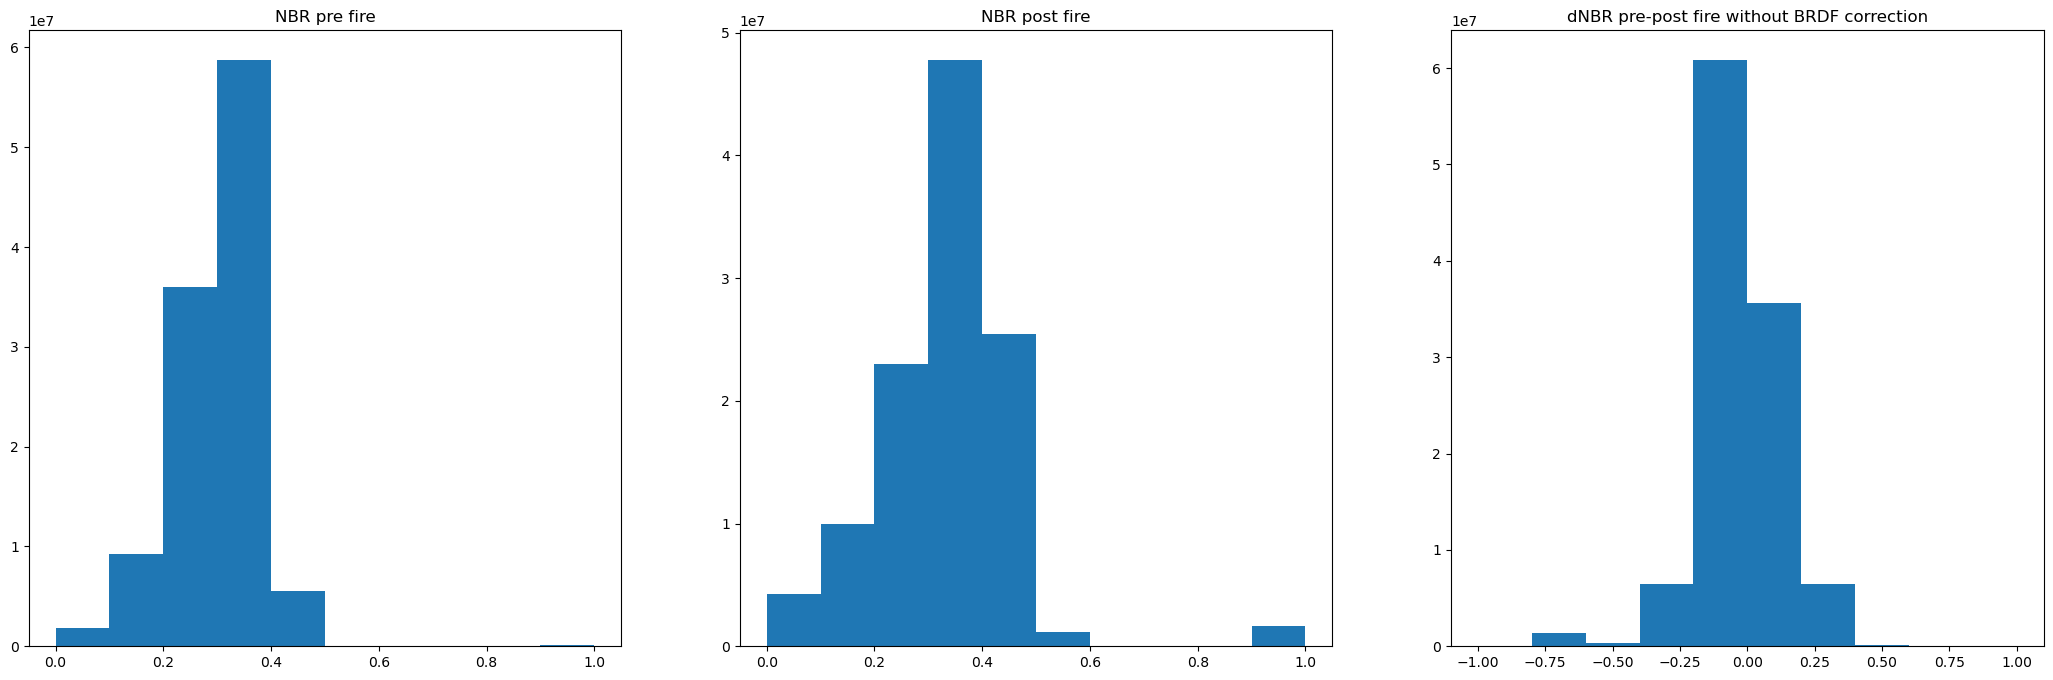

In [18]:
fig, axes = plt.subplots(1,3,figsize=(26,8)) #

axes[0].hist(nbr_raws["pre_fire"].values.ravel())
axes[0].set_title("NBR pre fire")

axes[1].hist(nbr_raws["post_fire"].values.ravel())
axes[1].set_title("NBR post fire")

axes[2].hist(dNBR_post_raw.values.ravel())
axes[2].set_title("dNBR pre-post fire without BRDF correction")


fig.savefig(f'images/masked/Landsat/NBR_histogram_event_{fire_id}.png', dpi=300)

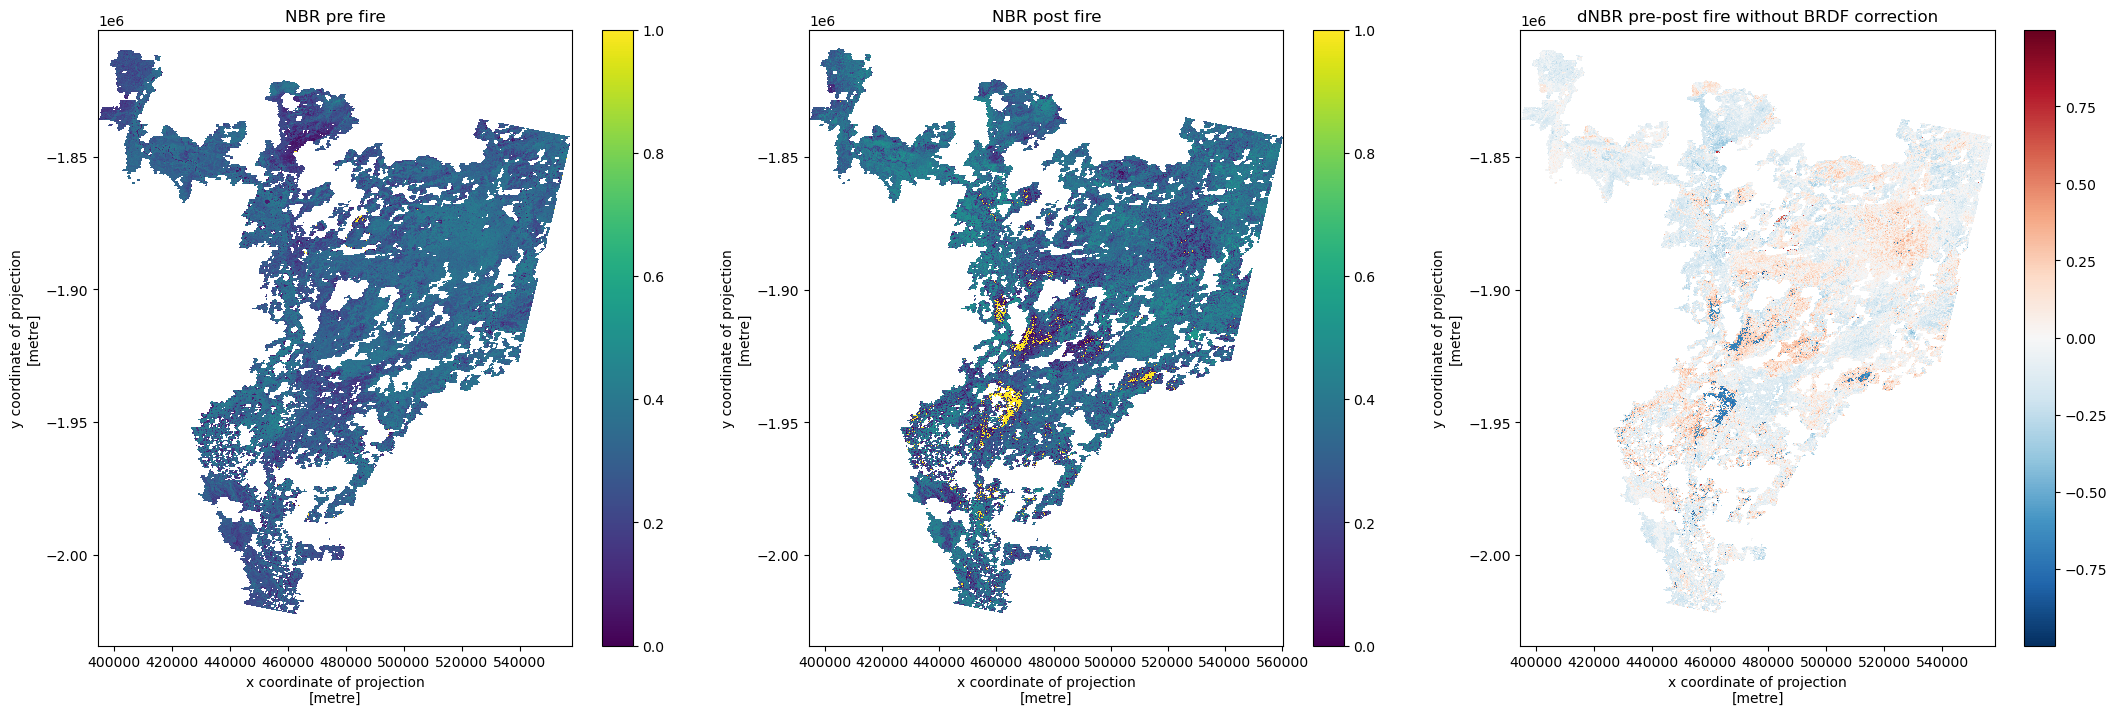

In [19]:
fig, axes = plt.subplots(1,3,figsize=(26,8)) #

nbr_raws["pre_fire"].plot.imshow(ax=axes[0])
axes[0].set_title("NBR pre fire")



nbr_raws["post_fire"].plot.imshow(ax=axes[1])
axes[1].set_title("NBR post fire")


dNBR_post_raw.plot.imshow(ax=axes[2])
axes[2].set_title("dNBR pre-post fire without BRDF correction")


fig.savefig(f'images/masked/Landsat/dNBR_event_{fire_id}.png', dpi=300)

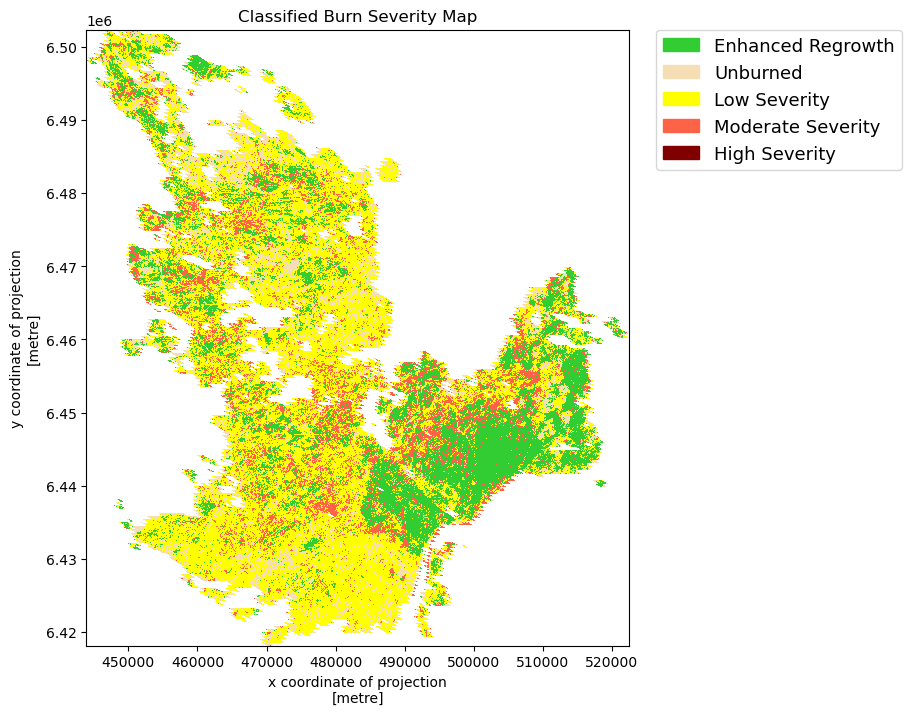

In [19]:
# Severity definitions taken from https://www.earthdatascience.org/courses/earth-analytics/multispectral-remote-sensing-modis/normalized-burn-index-dNBR/

severity_bins = [np.nanmin(dNBR_post_raw.values), -0.1, 0.1, 0.27, 0.66, np.nanmax(dNBR_post_raw.values)]

dNBR_post_raw_class = xr.apply_ufunc(np.digitize,
                                     dNBR_post_raw,
                                     severity_bins)

# Mask out values not equalt to 6 which represents Nan values
dNBR_post_raw_class_ma = dNBR_post_raw_class.where(dNBR_post_raw_class != 6)


# Plot data using nicer colors
colors = ['limegreen', 'wheat', 'yellow', 'tomato', 'maroon']
severity_labels = ["Enhanced Regrowth",
                   "Unburned",
                   "Low Severity",
                   "Moderate Severity",
                   "High Severity"]

class_bins = [.5, 1.5, 2.5, 3.5, 4.5, 5.5]

cmap = ListedColormap(colors)
norm = BoundaryNorm(class_bins, 
                    len(colors))


fig, ax = plt.subplots(figsize=(7, 8))
plot = dNBR_post_raw_class_ma.plot.imshow(cmap=cmap,
                                        norm=norm,
                                        # Turn off colorbar
                                        add_colorbar=False)
# Add legend using earthpy
draw_legend(plot,titles=severity_labels)
ax.set(title="Classified Burn Severity Map")

fig.savefig(f'images/masked/Landsat/classified_dNBR_event_{fire_id}.png', dpi=300, bbox_inches='tight')

In [20]:
for image_dir, label in zip(file_address, labels):
    f_name = os.path.join(image_dir.split("\\")[0], f'NBR_{label}.tif')
    nbr_raws[label].rio.to_raster(f_name)

In [21]:
f_name_diff = os.path.join(image_dir.split("\\")[0], f'dNBR pre-post fire.tif')
dNBR_post_raw.rio.to_raster(f_name_diff)

In [22]:
MASK_IMAGES = False

In [23]:
rgb_images = dict.fromkeys(labels, None)
for image_dir, label in zip(file_address, labels):
    rgb = open_RGB(image_dir, "TIF", False, False)
    rgb_images[label] = rgb
    f_name = os.path.join(image_dir.split("\\")[0], f'RGB_{label}.tif')
    rgb_images[label].rio.to_raster(f_name)

In [24]:
fcc_images = dict.fromkeys(labels, None)

for image_dir, label in zip(file_address, labels):
    rgb = open_false_color(image_dir, "TIF", False, False)
    fcc_images[label] = rgb
    f_name = os.path.join(image_dir.split("\\")[0], f'false_color_{label}.tif')
    fcc_images[label].rio.to_raster(f_name)

In [17]:
nir_pre.shape, nir_post.shape

((23223, 16350), (23193, 16590))

In [18]:
swir_pre.shape, swir_post.shape

((23223, 16350), (23193, 16590))

In [15]:
nir_pre = np.ma.array(SR_images[0].sel(band="nir"), mask=np.isnan(SR_images[0].sel(band="nir")))
nir_post = np.ma.array(SR_images[1].sel(band="nir"), mask=np.isnan(SR_images[1].sel(band="nir")))

In [16]:
swir_pre = np.ma.array(SR_images[0].sel(band="swir"), mask=np.isnan(SR_images[0].sel(band="swir")))
swir_post = np.ma.array(SR_images[1].sel(band="swir"), mask=np.isnan(SR_images[1].sel(band="swir")))

ValueError: operands could not be broadcast together with shapes (23193,16590) (23223,16350) 

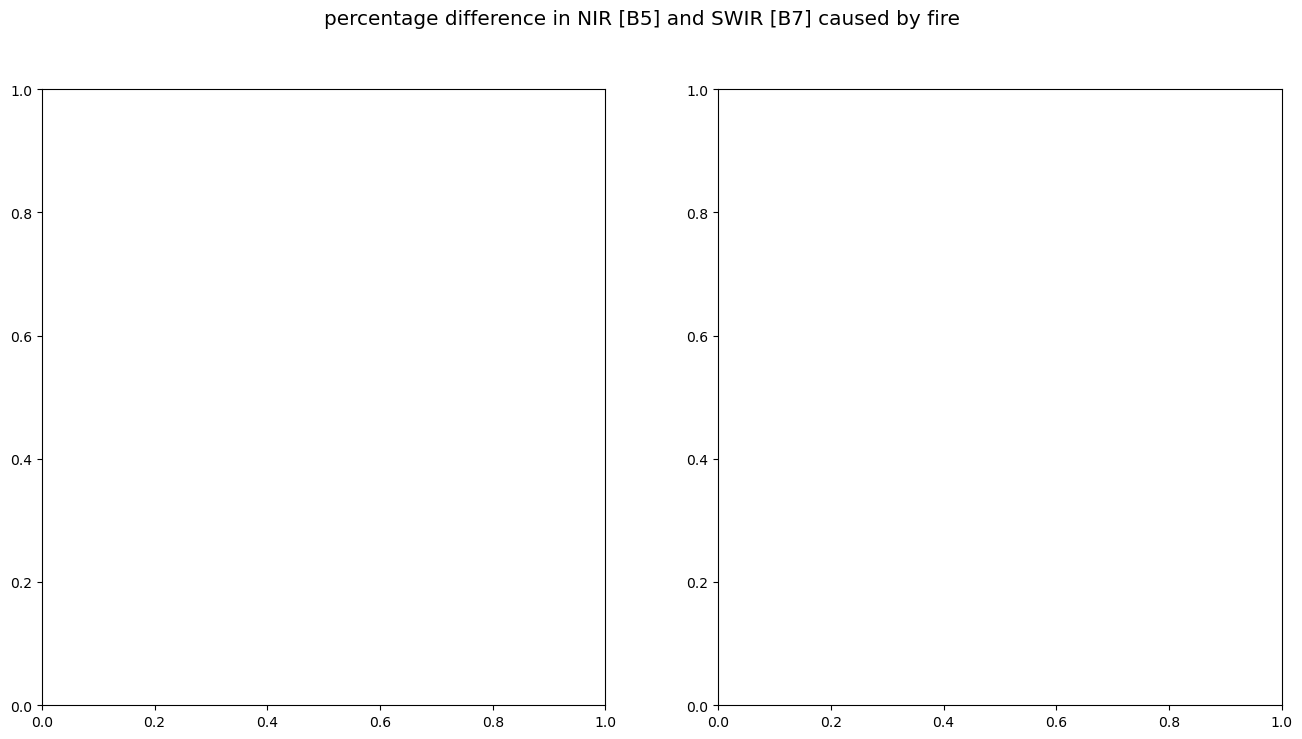

In [19]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("percentage difference in NIR [B5] and SWIR [B7] caused by fire", fontsize="x-large")

nir_diff = ((nir_post-nir_pre)/nir_pre)*100
swir_diff = ((swir_post-swir_pre)/swir_pre)*100

axes[0].hist(nir_diff.ravel())
axes[1].hist(swir_diff.ravel())

axes[0].set_title("NIR")
axes[1].set_title("SWIR")

# fig.savefig(f'images/masked/Landsat/NIR_and_SWIR_difference_event_{fire_id}.png', dpi=300)

In [20]:
nir_pre = SR_images[0].sel(band="nir")
nir_post = SR_images[1].sel(band="nir")

In [21]:
swir_pre = SR_images[0].sel(band="swir")
swir_post = SR_images[1].sel(band="swir")

(array([2.71550412e+08, 5.82813400e+06, 9.96723520e+07, 7.15789400e+06,
        4.48062000e+05, 1.10033000e+05, 4.86800000e+03, 1.03000000e+02,
        9.00000000e+00, 3.00000000e+00]),
 array([    0.,  3323.,  6646.,  9969., 13292., 16615., 19938., 23261.,
        26584., 29907., 33230.]),
 <BarContainer object of 10 artists>)

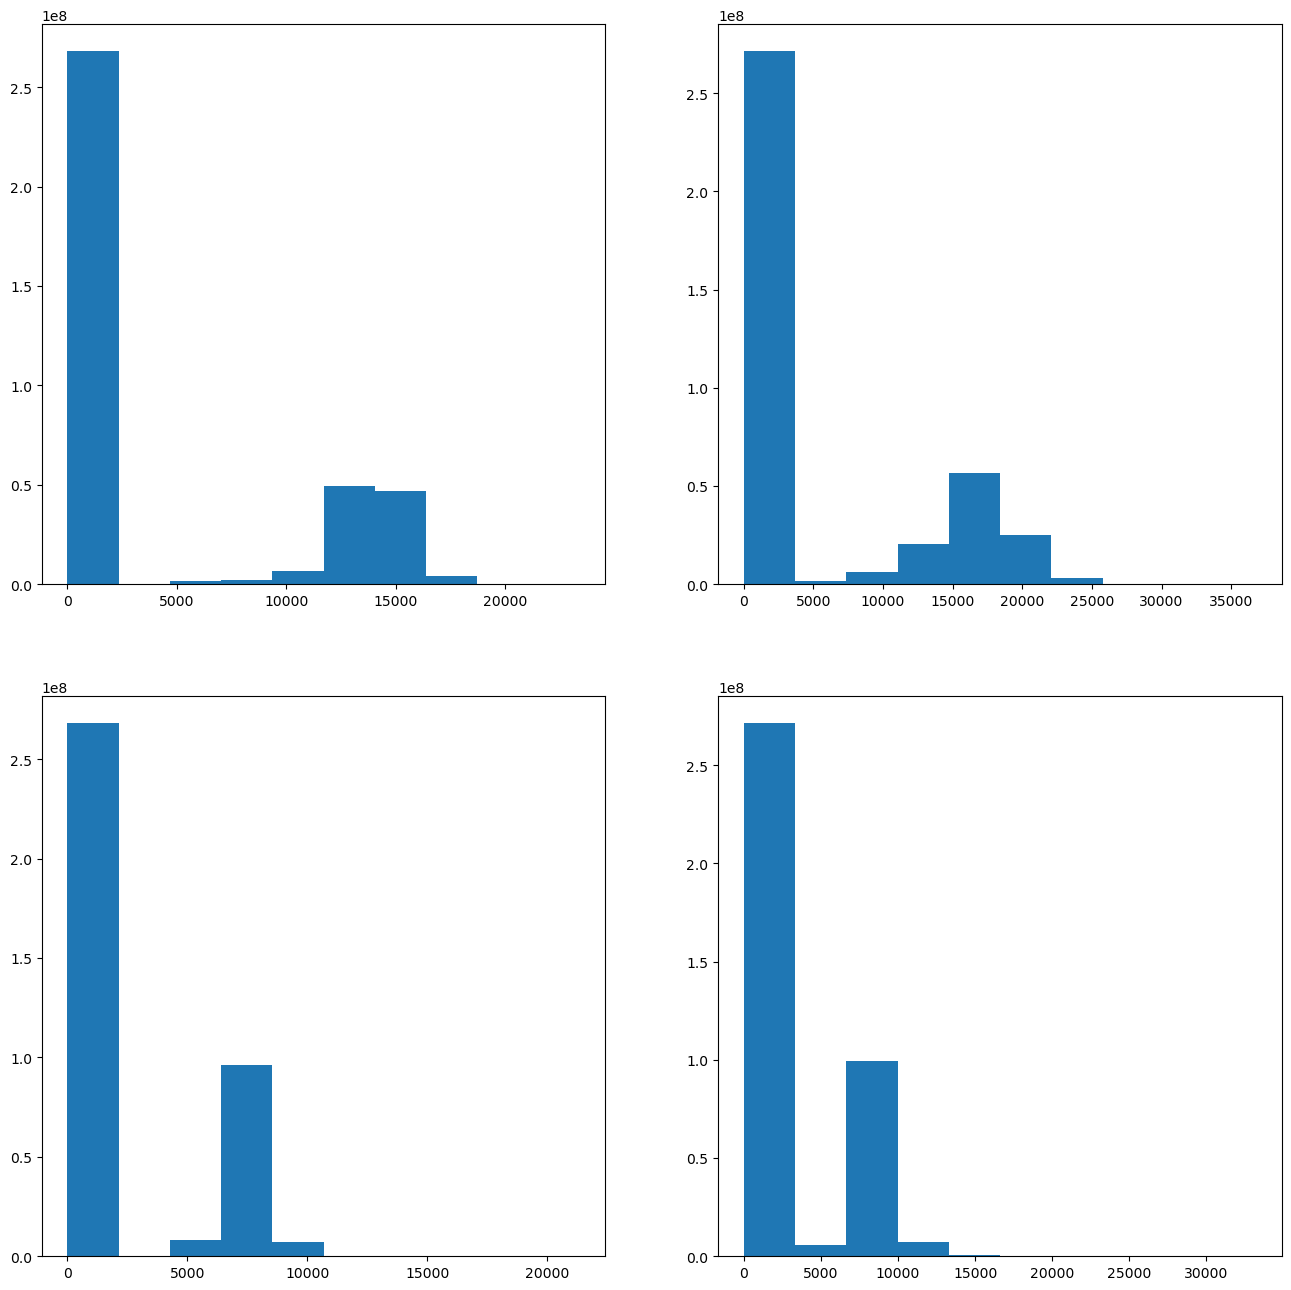

In [30]:
fig, axes = plt.subplots(2,2, figsize=(16,16))

axes[0][0].hist(nir_pre.values.ravel())
axes[0][1].hist(nir_post.values.ravel())

axes[1][0].hist(swir_pre.values.ravel())
axes[1][1].hist(swir_post.values.ravel())

ValueError: supplied range of [0.0, inf] is not finite

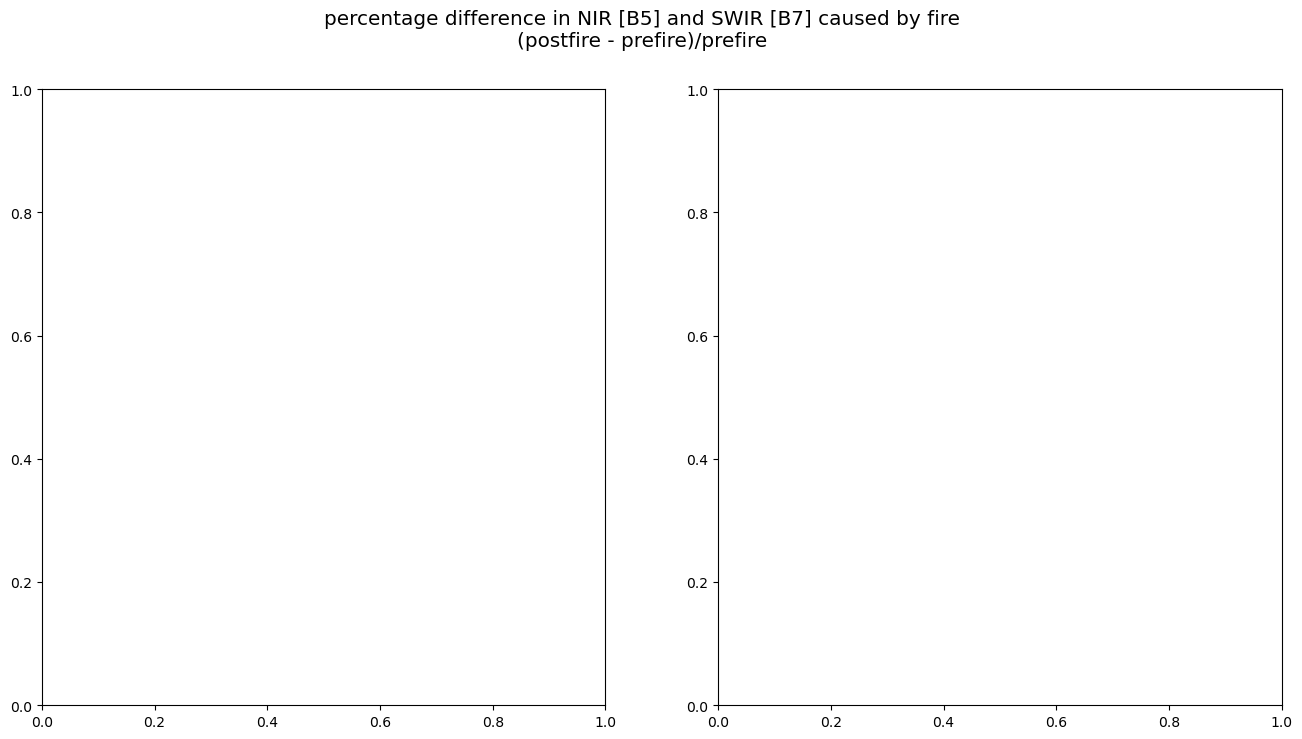

In [22]:
fig, axes = plt.subplots(1,2, figsize=(16,8))
st = fig.suptitle("percentage difference in NIR [B5] and SWIR [B7] caused by fire\n(postfire - prefire)/prefire", fontsize="x-large")

nir_diff = ((nir_post-nir_pre)/nir_pre)*100
swir_diff = ((swir_post-swir_pre)/swir_pre)*100

axes[0].hist(nir_diff.values.ravel())
axes[1].hist(swir_diff.values.ravel())

axes[0].set_title("NIR")
axes[1].set_title("SWIR")

fig.savefig(f'images/masked/Landsat/NIR_and_SWIR_difference_event_{fire_id}.png', dpi=300)

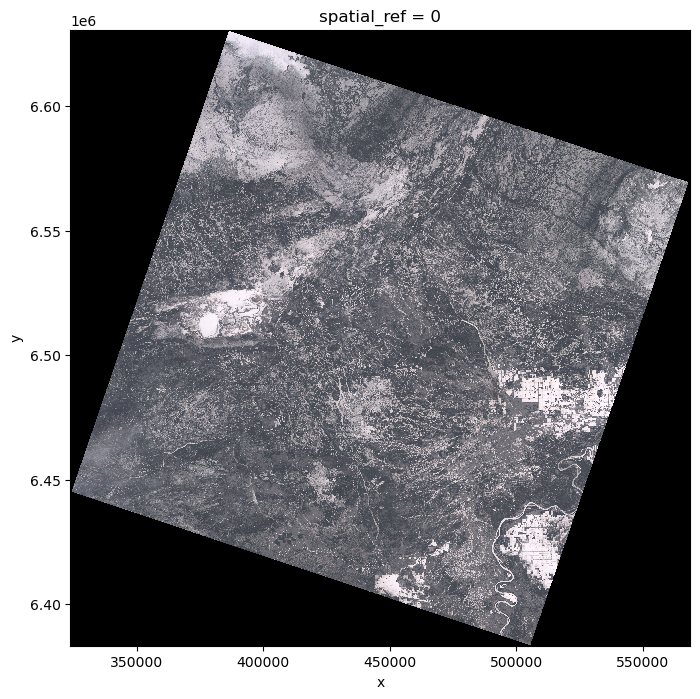

In [42]:
fig, axes = plt.subplots(figsize=(8,8))
(c/25000).clip(0,1).plot.imshow(ax=axes)
# fig.savefig(f'images/masked/RGB_event_{fire_id}_pre_{files[0].split("_")[2]}.png', dpi=300)